In [99]:
import numpy as np
import pandas as pd

# 读取数据
file_path = "DailyPrices.csv"
df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
df = df.sort_index()  # 按时间排序

# 选择股票
stock_list = ["SPY", "AAPL", "EQIX"]
df = df[stock_list]  # 只保留 SPY, AAPL, EQIX

### **A. 计算算术收益率**
arithmetic_returns = df.pct_change().dropna()  # 计算日收益率
arithmetic_returns -= arithmetic_returns.mean()  # 去均值

# 计算每个股票的标准差
arithmetic_std = arithmetic_returns.std()

# 展示结果
print("\n--- Arithmetic Returns (Last 5 Rows) ---")
print(arithmetic_returns.tail())  # 展示最后 5 行
print("\n--- Arithmetic Returns Standard Deviation ---")
print(arithmetic_std)

### **B. 计算对数收益率**
log_returns = np.log(df / df.shift(1)).dropna()  # 计算 log return
log_returns -= log_returns.mean()  # 去均值

# 计算每个股票的标准差
log_std = log_returns.std()

# 展示结果
print("\n--- Log Returns (Last 5 Rows) ---")
print(log_returns.tail())  # 展示最后 5 行
print("\n--- Log Returns Standard Deviation ---")
print(log_std)



--- Arithmetic Returns (Last 5 Rows) ---
                 SPY      AAPL      EQIX
Date                                    
2024-12-27 -0.011492 -0.014678 -0.006966
2024-12-30 -0.012377 -0.014699 -0.008064
2024-12-31 -0.004603 -0.008493  0.006512
2025-01-02 -0.003422 -0.027671  0.000497
2025-01-03  0.011538 -0.003445  0.015745

--- Arithmetic Returns Standard Deviation ---
SPY     0.008077
AAPL    0.013483
EQIX    0.015361
dtype: float64

--- Log Returns (Last 5 Rows) ---
                 SPY      AAPL      EQIX
Date                                    
2024-12-27 -0.011515 -0.014675 -0.006867
2024-12-30 -0.012410 -0.014696 -0.007972
2024-12-31 -0.004577 -0.008427  0.006602
2025-01-02 -0.003392 -0.027930  0.000613
2025-01-03  0.011494 -0.003356  0.015725

--- Log Returns Standard Deviation ---
SPY     0.008078
AAPL    0.013446
EQIX    0.015270
dtype: float64


In [100]:
import numpy as np
import pandas as pd
from scipy.stats import norm, t
from scipy.optimize import minimize

file_path = "DailyPrices.csv"
df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
df = df.sort_index()  

stock_list = ["SPY", "AAPL", "EQIX"]
df = df[stock_list] 

returns = df.pct_change().dropna()

returns = returns - returns.mean()

portfolio_weights = np.array([100, 200, 150]) 
current_prices = df.iloc[-1].values  
portfolio_value = np.sum(portfolio_weights * current_prices)  

portfolio_returns = returns @ (portfolio_weights * current_prices) / portfolio_value

var_results = {}
es_results = {}

lambda_ewma = 0.97
weights = (1 - lambda_ewma) * lambda_ewma ** np.arange(len(returns))[::-1]
weights /= weights.sum()

for stock in stock_list:
    std_ewma = np.sqrt(np.sum(weights * returns[stock] ** 2))
    var_norm = norm.ppf(0.05) * std_ewma
    var_historical = np.percentile(returns[stock], 5)

    def neg_log_likelihood(params):
        df_t, sigma_t = params
        return -np.sum(t.logpdf(returns[stock], df=df_t, scale=sigma_t))

    res = minimize(neg_log_likelihood, x0=[5, returns[stock].std()], bounds=[(2, 50), (0.0001, None)])
    df_t, sigma_t = res.x
    var_t = t.ppf(0.05, df=df_t) * sigma_t

    es_norm = returns[stock][returns[stock] <= var_norm].mean()
    es_t = returns[stock][returns[stock] <= var_t].mean()
    es_historical = returns[stock][returns[stock] <= var_historical].mean()

    var_results[stock] = {"Normal": var_norm, "T-Dist": var_t, "Historical": var_historical}
    es_results[stock] = {"Normal": es_norm, "T-Dist": es_t, "Historical": es_historical}

var_norm_portfolio = norm.ppf(0.05) * np.sqrt(np.sum(weights * portfolio_returns ** 2))
var_t_portfolio = t.ppf(0.05, df=df_t) * sigma_t
var_historical_portfolio = np.percentile(portfolio_returns, 5)

es_norm_portfolio = portfolio_returns[portfolio_returns <= var_norm_portfolio].mean()
es_t_portfolio = portfolio_returns[portfolio_returns <= var_t_portfolio].mean()
es_historical_portfolio = portfolio_returns[portfolio_returns <= var_historical_portfolio].mean()

print(f"Portfolio Value: ${portfolio_value:,.2f}")

print("\n--- Individual Stock VaR & ES ---")
for stock in stock_list:
    stock_index = stock_list.index(stock) 
    stock_value = portfolio_weights[stock_index] * current_prices[stock_index]  

    print(f"\n{stock}:")
    print(f"  VaR (Normal): ${abs(var_results[stock]['Normal'] * stock_value):,.2f}")
    print(f"  VaR (T-Dist): ${abs(var_results[stock]['T-Dist'] * stock_value):,.2f}")
    print(f"  VaR (Historical): ${abs(var_results[stock]['Historical'] * stock_value):,.2f}")
    print(f"  ES (Normal): ${abs(es_results[stock]['Normal'] * stock_value):,.2f}")
    print(f"  ES (T-Dist): ${abs(es_results[stock]['T-Dist'] * stock_value):,.2f}")
    print(f"  ES (Historical): ${abs(es_results[stock]['Historical'] * stock_value):,.2f}")

print("\n--- Portfolio VaR & ES ---")
print(f"VaR (Normal): ${abs(var_norm_portfolio * portfolio_value):,.2f}")
print(f"VaR (T-Dist): ${abs(var_t_portfolio * portfolio_value):,.2f}")
print(f"VaR (Historical): ${abs(var_historical_portfolio * portfolio_value):,.2f}")
print(f"ES (Normal): ${abs(es_norm_portfolio * portfolio_value):,.2f}")
print(f"ES (T-Dist): ${abs(es_t_portfolio * portfolio_value):,.2f}")
print(f"ES (Historical): ${abs(es_historical_portfolio * portfolio_value):,.2f}")


Portfolio Value: $251,862.50

--- Individual Stock VaR & ES ---

SPY:
  VaR (Normal): $827.85
  VaR (T-Dist): $774.88
  VaR (Historical): $872.40
  ES (Normal): $1,056.91
  ES (T-Dist): $1,018.48
  ES (Historical): $1,080.10

AAPL:
  VaR (Normal): $946.08
  VaR (T-Dist): $1,030.11
  VaR (Historical): $1,067.11
  ES (Normal): $1,324.49
  ES (T-Dist): $1,409.73
  ES (Historical): $1,437.79

EQIX:
  VaR (Normal): $2,933.51
  VaR (T-Dist): $3,406.99
  VaR (Historical): $3,635.08
  ES (Normal): $4,255.14
  ES (T-Dist): $4,669.60
  ES (Historical): $4,714.89

--- Portfolio VaR & ES ---
VaR (Normal): $3,856.32
VaR (T-Dist): $5,959.16
VaR (Historical): $4,575.03
ES (Normal): $5,449.90
ES (T-Dist): $7,425.65
ES (Historical): $6,059.39


(A) Implied Volatility = 33.51%
(B) Call:
    Delta = 0.6659
    Vega  = 5.6407
    Theta  = -5.5446
    volatility increases by 1% = 0.0564
    Put:
    Delta = -0.3341
    Theta = -2.6186
(C) Put Price  = 1.2593
    LHS  = 1.7407, RHS  = 1.7407
    Put-Call Parity holds: Yes
(D) Portfolio Composition:
    Call Value = 3.0000
    Put Value  = 1.2593
    Stock Value = 31.0000
    Portfolio Value = 35.2593
Call Greeks: Delta = 0.6659, Theta = -5.5446
Put Greeks: Delta = -0.3341, Theta = -2.6186
    Portfolio Delta = 1.3319
    Portfolio Theta = -8.1632
(D) Delta Normal Approximation (20days with 5% confidence level):
    Mean Portfolio Change = -0.6403
    Std Portfolio Change = 2.1704
    VaR(5%) = 4.2103
    ES(5%)  = 3.8367
(E) Monte Carlo Simulation (20days, with 5% confidence level):
    VaR(5%) = 3.3695
    ES(5%)  = 4.1637



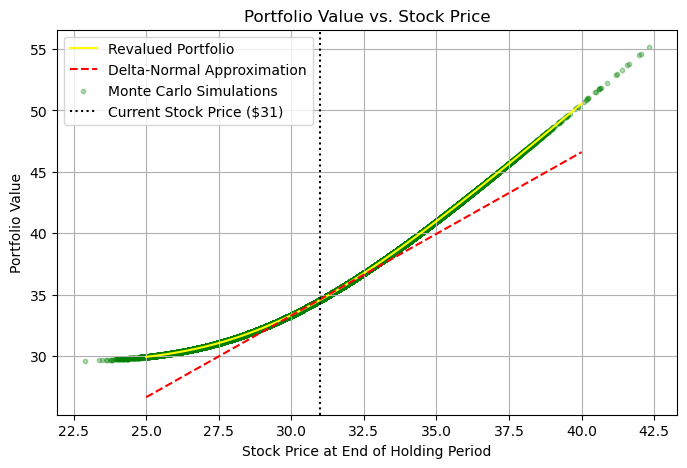

In [101]:
import numpy as np
import math
from scipy.stats import norm
from scipy.optimize import fsolve

def black_scholes_call(S, K, r, T, sigma):
    if T <= 0:
        return max(S - K, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, r, T, sigma):
    if T <= 0:
        return max(K - S, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def implied_volatility(C, S, K, r, T):
    def objective(sigma):
        return black_scholes_call(S, K, r, T, sigma) - C
    return fsolve(objective, 0.2)[0]  # Initial guess is 0.2

def delta_call(S, K, r, T, sigma):
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    return norm.cdf(d1)

def delta_put(S, K, r, T, sigma):
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    return -norm.cdf(-d1)

def vega(S, K, r, T, sigma):
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    return S * norm.pdf(d1) * math.sqrt(T)

def theta_call(S, K, r, T, sigma):
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return -(S * norm.pdf(d1) * sigma) / (2.0 * math.sqrt(T)) - r * K * math.exp(-r * T) * norm.cdf(d2)

def theta_put(S, K, r, T, sigma):
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return -(S * norm.pdf(d1) * sigma) / (2.0 * math.sqrt(T)) + r * K * math.exp(-r * T) * norm.cdf(-d2)

# Main function
def main():
    # Parameters
    S = 31.0  # Stock price
    K = 30.0  # Strike price
    r = 0.10  # Risk-free rate
    T = 0.25  # Time to maturity (in years)
    C_obs = 3.00  # Observed call price

    # A) Calculate implied volatility
    sigma_imp = implied_volatility(C_obs, S, K, r, T)
    print(f"(A) Implied Volatility = {sigma_imp * 100:.2f}%")

    # B) Calculate Greeks
    delta_c = delta_call(S, K, r, T, sigma_imp)
    delta_p = delta_put(S, K, r, T, sigma_imp)
    vega_val = vega(S, K, r, T, sigma_imp)
    theta_c = theta_call(S, K, r, T, sigma_imp)
    theta_p = theta_put(S, K, r, T, sigma_imp)

    print(f"(B) Call:")
    print(f"    Delta = {delta_c:.4f}")
    print(f"    Vega  = {vega_val:.4f}")
    print(f"    Theta  = {theta_c:.4f}")
    price_change_vol_up_1pct = vega_val * 0.01
    print(f"    volatility increases by 1% = {price_change_vol_up_1pct:.4f}")

    print(f"    Put:")
    print(f"    Delta = {delta_p:.4f}")
    print(f"    Theta = {theta_p:.4f}")

    # C) Calculate put price and verify Put-Call Parity
    put_price = black_scholes_put(S, K, r, T, sigma_imp)
    print(f"(C) Put Price  = {put_price:.4f}")
    lhs = C_obs - put_price
    rhs = S - K * math.exp(-r * T)
    print(f"    LHS  = {lhs:.4f}, RHS  = {rhs:.4f}")
    print(f"    Put-Call Parity holds: {'Yes' if np.isclose(lhs, rhs, atol=1e-4) else 'No'}")

    # D) Portfolio value
    call_value = C_obs
    put_value = put_price
    stock_value = S
    portfolio_value = call_value + put_value + stock_value
    print(f"(D) Portfolio Composition:")
    print(f"    Call Value = {call_value:.4f}")
    print(f"    Put Value  = {put_value:.4f}")
    print(f"    Stock Value = {stock_value:.4f}")
    print(f"    Portfolio Value = {portfolio_value:.4f}")

    # Portfolio Delta and Theta
    portfolio_delta = delta_c + delta_p + 1  # 1 share of stock
    portfolio_theta = theta_c + theta_p
    print(f"Call Greeks: Delta = {delta_c:.4f}, Theta = {theta_c:.4f}")
    print(f"Put Greeks: Delta = {delta_p:.4f}, Theta = {theta_p:.4f}")
    print(f"    Portfolio Delta = {portfolio_delta:.4f}")
    print(f"    Portfolio Theta = {portfolio_theta:.4f}")

    # D) Delta Normal Approximation for VaR and ES
    holding_days = 20
    days_per_year = 255
    alpha = 0.05
    annual_vol = 0.25
    sigma_20day = annual_vol * math.sqrt(holding_days / days_per_year)
    std_dS_20 = S * sigma_20day
    mean_dS_20 = portfolio_theta * (holding_days / days_per_year)  # Include Theta effect
    z_alpha = norm.ppf(alpha)
    VaR_delta_normal = -(mean_dS_20 + std_dS_20 * z_alpha)
    ES_delta_normal = -(mean_dS_20 + std_dS_20 * (norm.pdf(z_alpha) / alpha))
    ES_delta_normal = abs(ES_delta_normal)
    print("(D) Delta Normal Approximation (20days with 5% confidence level):")
    print(f"    Mean Portfolio Change = {mean_dS_20:.4f}")
    print(f"    Std Portfolio Change = {std_dS_20:.4f}")
    print(f"    VaR(5%) = {VaR_delta_normal:.4f}")
    print(f"    ES(5%)  = {ES_delta_normal:.4f}")

    # E) Monte Carlo Simulation for VaR and ES
    np.random.seed(42)
    n_sims = 100000
    random_changes = np.random.normal(0, sigma_20day, n_sims)
    S_final = S * np.exp(random_changes)
    portfolio_changes = S_final - S
    sorted_changes = np.sort(portfolio_changes)
    cutoff_index = int(alpha * n_sims)
    var_mc = -sorted_changes[cutoff_index]
    worse_losses = sorted_changes[:cutoff_index]
    ES_mc = -np.mean(worse_losses)
    print("(E) Monte Carlo Simulation (20days, with 5% confidence level):")
    print(f"    VaR(5%) = {var_mc:.4f}")
    print(f"    ES(5%)  = {ES_mc:.4f}\n")

if __name__ == "__main__":
    main()
    plt.figure(figsize=(8, 5))
    plt.plot(S_range, portfolio_values_curve, label='Revalued Portfolio', color='yellow')
    plt.plot(S_range, linear_approx, label='Delta-Normal Approximation', linestyle='--', color='red')
    plt.scatter(S_final, portfolio_values, s=10, alpha=0.3, color='green', label='Monte Carlo Simulations')
    plt.axvline(x=S, color='black', linestyle=':', label=f'Current Stock Price (${S})')
    plt.xlabel('Stock Price at End of Holding Period')
    plt.ylabel('Portfolio Value')
    plt.title('Portfolio Value vs. Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

The Delta-Normal approximation provides a simple and computationally efficient method for risk estimation but fails to capture non-linearity, especially for large stock price movements. In contrast, Monte Carlo simulation is more accurate as it accounts for convexity, Gamma effects, and volatility sensitivity, making it the preferred method for complex risk analysis.